In [1]:
import xarray as xr # top library for manipulating netcdf files
import netCDF4 # more basic library for manipulating netcdf files, used for exploring
import matplotlib.pyplot as plt # ploting library

# Get familiarized with netcdf files
Netcdf files, or files with an .nc extension are containers for complex datasets, and can store any kind of information.
You can read more about NetCDF here: https://www.unidata.ucar.edu/software/netcdf/. 
They are mostly used to store grided datasets (e.g. data is stored in some dimensional grid, in which each point of data is located in some (x) or (x,y) or (x,y,z) or higer multidimensional space.
Satelite data files are usualy delivered as .nc, but there are several layers of information that should be unraveled before geting to the data and the location of the data.

In [2]:
#get this file from slack or dowload one from oceancolor
path = 'AQUA_MODIS.20220118T190501.L2.SST.NRT.nc'
ds = xr.open_dataset(path)
nc = netCDF4.Dataset(path)

In [2]:
#get this file from slack or dowload one from oceancolor
path = 'AQUA_MODIS.20220118T190501.L2.SST.NRT.nc'
ds = xr.open_dataset(path)
nc = netCDF4.Dataset(path)

We are using two different libraries to look at the same file.

Xarray (https://www.unidata.ucar.edu/software/netcdf/) is a more powerfull, high end library, and is the one we are going to use to build most of our tools. 

NetCDF4 is a basic library and is a python wrapper for the base netcdf software (from the unidata link). Is what was used to manipulate the data before xarray was developed. We are going to use it to explore the bones of the file, but not in production.

In [3]:
#take some time to click around on the output bellow and loos at what the file contains.
ds

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*
Attributes: (12/48)
    product_name:                      A2021274.L3b_DAY_IOP.x.nc
    title:                             MODIS Level-3 Binned Data
    instrument:                        MODIS
    platform:                          Aqua
    temporal_range:                    day
    start_orbit_number:                103245
    ...                                ...
    processing_level:                  L3 Binned
    cdm_data_type:                     point
    identifier_product_doi_authority:  https://dx.doi.org
    identifier_product_doi:            10.5067/AQUA/MODIS/L3B/IOP/2018
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    keywords:                          Earth Science > Oceans > Ocean Optics ...

In [4]:
#this file visualization is not interactive as the file above, 
#but it gives you some information that xaray skips, because sat products don't follow
#the regular convention other kinds of product follow for data
#as a general rule: 
#if you open a netcdf file and there is no information under data variables
#it means that the data is stored in groups, and you have to extract it from groups
#look for groups at the end of this file output
nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    product_name: A2021274.L3b_DAY_IOP.x.nc
    title: MODIS Level-3 Binned Data
    instrument: MODIS
    platform: Aqua
    temporal_range: day
    start_orbit_number: 103245
    end_orbit_number: 103261
    date_created: 2022008214354000
    processing_version: unspecified
    history: /sdps/sdpsoper/Science/OCSSW/V2021.1/bin/l3bin ifile=A2021274.L3b_DAY_IOP.nc ofile=A2021274.L3b_DAY_IOP.x.nc latnorth=35.0600 latsouth=21.6000 lonwest=-98.8600 loneast=-78.9000
    time_coverage_start: 2021-10-01T00:00:00.000Z
    time_coverage_end: 2021-10-02T02:30:00.000Z
    northernmost_latitude: 30.645834
    southernmost_latitude: 21.604166
    easternmost_longitude: -78.854195
    westernmost_longitude: -94.414665
    geospatial_lat_max: 30.64583396911621
    geospatial_lat_min: 21.60416603088379
    geospatial_lon_max: -78.85419464111328
    geospatial_lon_min: -94.41466522216797
    geospatial_lat_units: deg

In [5]:
#here we can list the groups
#note: this for is called list comprehension in python and is a way of creating a list
#not using a for loop
[g for g in nc.groups]

['level-3_binned_data', 'processing_control']

In [6]:
#in loop form:

for g in nc.groups:
    print(g)

level-3_binned_data
processing_control


In [7]:
# now load the data in xarray
data = xr.open_dataset(path, group='geophysical_data')
navigation = xr.open_dataset(path, group='navigation_data')

OSError: [Errno group not found: geophysical_data] 'geophysical_data'

In [8]:
# add cells and explore data and navigation
# navigation has lat lon information
# data has geophysical data
# explore the other groups to see what they have
# it would be easier to have lat lon in the same file as the data

We created the funtion bellow after exploration, so the steps we did can be repeated easily with any other files

In [9]:
def load_satdata(path):
    # Reads a MODIS data file
    # input: file name
    # output: a dataset with all the adjustments we did to inlude lat and lon
    data = xr.open_dataset(path, group='geophysical_data')
    navigation = xr.open_dataset(path, group='navigation_data')
    # rename the names of navigation dims so they are the same as the data dims
    # you can see the names of the dims in you individual dataset exploration.
    # both files have the same shape (they correspond to the same points)
    # but the names are different. so we have to fix that to be able to combine both
    navigation = navigation.rename({'pixel_control_points': 'pixels_per_line'})
    # we have to filter data that doesnt have lat or lon values (nan), 
    # because there can't be a data point without a location
    # ~ means no, ~().isnull(), means give me the values that are NOT nans
    mask = (~navigation['latitude'].isnull()) & (~navigation['longitude'].isnull())
    # filter to get only data with lat/lon values
    data = data.where(mask, drop=True)
    # add 'lat', 'lon' variables to data, from the navigation dataset
    data['lat'] = navigation['latitude'].where(mask, drop=True)
    data['lon'] = navigation['longitude'].where(mask, drop=True)
    # return the dataset
    return data

In [10]:
# ds is a Dataset
# ds['sst'] is a Dataarray, a variable in the dataset
# explore

ds = load_satdata(path)
ds

<xarray.Dataset>
Dimensions:    (number_of_lines: 2020, pixels_per_line: 1354)
Dimensions without coordinates: number_of_lines, pixels_per_line
Data variables:
    sst        (number_of_lines, pixels_per_line) float32 19.8 20.57 ... nan nan
    qual_sst   (number_of_lines, pixels_per_line) float32 3.0 3.0 ... 4.0 4.0
    flags_sst  (number_of_lines, pixels_per_line) float32 -1.248e+03 ... 1.0
    bias_sst   (number_of_lines, pixels_per_line) float32 -14.59 ... -18.0
    stdv_sst   (number_of_lines, pixels_per_line) float32 13.26 13.26 ... -18.0
    sstref     (number_of_lines, pixels_per_line) float32 26.93 26.95 ... nan
    l2_flags   (number_of_lines, pixels_per_line) float64 560.0 560.0 ... 50.0
    lat        (number_of_lines, pixels_per_line) float32 21.36 21.36 ... 35.56
    lon        (number_of_lines, pixels_per_line) float32 -74.1 ... -102.5

## some basic ploting
pcolormesh recives a data variable that has 2 dimensions (e.g xy) and plots a value (color) in an x-y space.

plt.pcolormesh(var) will work if var has two dimensions, but will not know what x or y are.

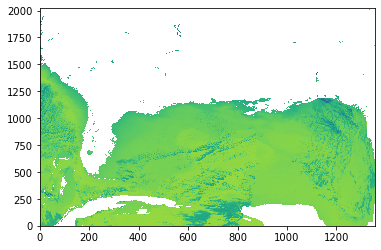

In [11]:
plt.pcolormesh(ds['sst'])
# but there is no location information on it (the map is fliped)

you can specify locations for x and y. x, y and var have to have the same shape
plt.pcolormesh(x, y, var)

/Users/hboi/miniconda3/envs/owl/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


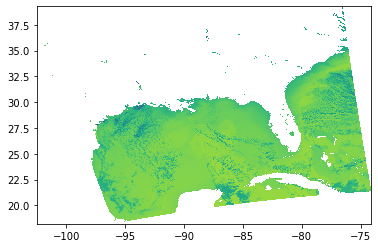

In [12]:
plt.pcolormesh(ds['lon'], ds['lat'], ds['sst'])

# Chalenge:

try to build a function to plot a variable from the dataset, restricted to a extent box.
The extent box wil have left, right (lon) and bottom, top (lat) bounds for the map.
Use the structure below to start builiding your function

In [14]:
def plot_map(ds, var, extent):
    ''' 
    Plots a map of a chosen variable from a dataset, bounded to a box
    input:
    ds : an xarray dataset
    var: a string, the name of a variable
    extent: a list of bounds on the form [left, right, bottom, top]
    ''' 
    #ds dataset should be reduced, with lat lon conditions
    ds = #something
    
    plt.pcolormesh(ds['lon'], ds['lat'], ds[var])

SyntaxError: invalid syntax (<ipython-input-14-2d050effa9f5>, line 10)

In [ ]:
#this should work if your function is correct
plot_map(ds, 'sst', [-95, -85, 27.7, 30.0])